In [1]:
import oritelib as orite
import matplotlib.pyplot as plt
import numpy as np

In [32]:
fasta_path = 'test_data/exciting_bacteria/Pseudomonas_aeruginosa_FASTA.fasta'
genbank_path  = 'test_data/exciting_bacteria/Pseudomonas_aeruginosa_GB.gb'


# Import fasta seq
seq = orite.seq_from_fasta(fasta_path)


In [33]:
# Max rotate 

max_things = orite.max_rotate_seq_and_skew_calc(seq)

max_cg = max_things[0]
max_cgc = max_things[1]
max_fasta = max_things[2]
max_offset = max_things[3]


inital max gc skew indx 1670293
max cgc skew indx 745403


In [34]:
# Z - curve
xn, yn, zn = orite.calc_z_curve(max_fasta)

RY = xn
KM = yn

In [35]:
# Normalize skews 
cgc_scaled = orite.scale_skew(max_cgc)
RY_scaled = orite.scale_skew(RY)
KM_scaled = orite.scale_skew(KM)

In [36]:
# Lets try moving on with a score curve of: (CGC_SCALED - KM_SCALED)_SCALED
score_curve = orite.scale_skew(cgc_scaled - KM_scaled) 

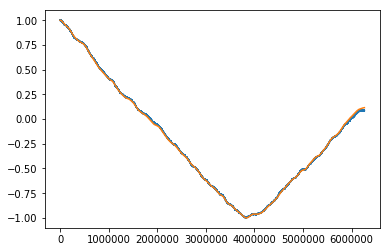

In [37]:
plt.plot(score_curve)
plt.plot(cgc_scaled)

In [38]:
# EXTRACT GENBANK INFORMATION and get all non coding regions with scores taken from the score-curve


g = orite.genbank_to_non_coding_intervals(genbank_path)

true_nc_intervals = g[0] # - List of touples
true_nc_positions = g[1] # - all NC positions in an arrays
non_coding_plus = g[2] # - nc regions interval touple list - WILL NOT BE USED
non_coding_neg  = g[3] # - nc regions interval touple list - WILL NOT BE USED


all_nc_regions = orite.get_phased_nc_region_list(true_nc_intervals, seq, max_offset, score_curve)
#print('total number of intial non coding regions: ', len(all_nc_regions))

In [39]:

# note that we take the negative of the avarage score and thus the below should be flipped
def filter_out_regions_above_score(region_list, score_thresh = -0.50):
    
    new_list = []
    
    neg_score = - score_thresh
    
    for region in region_list:
        if region.cgc_val > neg_score:
            new_list.append(region)
    
    return new_list 





# Removes row
def remove_kmer_rows_with_densisty_below_thresh(region, d_threshold):
    
    new_dict = dict()
    
    for k, rows_list in region.kmer_info.items():
        new_rows = []
        
        for row in rows_list:
            
            if row[2] > d_threshold:
                new_rows.append(row)
                
        new_dict.update({k:new_rows})

        #print({k:new_rows})
        
    
    region.kmer_info = new_dict
        
        






# WHOLE KMER FILTERING AND SORTING FUNCITON. 
# BEGINING WITH A ALL_NC_REGIONS LIST THAT HASNT HAD ITS KMERS COMPUTEDED. 
def prcoess_and_filter_all_nc_regions_list(all_nc_regions, 
                                           kmer_lengths_of_interest, 
                                           region_length_threshold=50, 
                                           occurance_threshold=3, 
                                          score_thresh = -0.75, 
                                          d_tresh = 0.01):
    
    
    print('Filtering process\nTotal number of intial non coding regions: ', len(all_nc_regions))
    
    
    # Filter based on region length threshold. Default is 50 base
    long_enough_regions = orite.filter_regions_by_length(all_nc_regions, region_length_threshold)
    print('Length filtering - number of nc regions above 50 in length: ', len(long_enough_regions))
    
    
    
    # Compute kmers info 
    x0 = orite.calc_kmers_from_region_list(long_enough_regions, kmer_lengths_of_interest)

    # Filter out kmers rows in each nc_objects kmer_info field based on occurances 
    regions_3_and_more_occ = orite.filter_region_list_by_kmer_occurence(x0, occurance_threshold)
    print('Kmer Occurence filtering - number of nc regions with kmers  having 3 or more occurances: ', len(regions_3_and_more_occ))

    
    # Compute densities for each kmer row of each nc_region
    regions_3_and_more_occ_with_density = orite.calc_density_for_region_list(regions_3_and_more_occ)

    # Remove regions containing overlapping repeats 
    regions_without_overlapping_repaets = orite.remove_overlapping_kmers_from_region_list(regions_3_and_more_occ_with_density)

    
    # Some regions might have only contained kmer rows with overlapping regions. 
    # Therefore we need to remove once more empty kmers. 

    x1 = orite.filter_empty_kmer_regions(regions_without_overlapping_repaets)
    
    #removes kets (kmer lengths with empty values )
    x2 = orite.filter_out_empty_kmer_key_in_region_list(x1)
    print('Overlapp filtering - number of nc regions without overlapping repeats: ', len(x2))

    # Keep only regions were 
    x3 = filter_out_regions_above_score(x2, score_thresh)
    
    print('Number of regions with scores "below" ', score_thresh ,': ', len(x3))
    
        
    x4 = orite.sort_region_list_on_density(x3)
    
    # This changes the list and doesnt return anything 
    orite.sort_regions_by_score(x4)
    
    
    ## 
    for region in x4:
        remove_kmer_rows_with_densisty_below_thresh(region, d_tresh)
        
    
    
    x5 = orite.filter_empty_kmer_regions(x4)
    
    #removes kets (kmer lengths with empty values )
    x6 = orite.filter_out_empty_kmer_key_in_region_list(x5)
    print('Number of regions with kmer_densities above ',d_tresh,' - ',   len(x6))

    
    
    print('\n---Done---')
    return x6


Filtering process
Total number of intial non coding regions:  4458
Length filtering - number of nc regions above 50 in length:  3105
Kmer Occurence filtering - number of nc regions with kmers  having 3 or more occurances:  247
Overlapp filtering - number of nc regions without overlapping repeats:  196
Number of regions with scores "below"  -0.75 :  38
Number of regions with kmer_densities above  0.01  -  35

---Done---


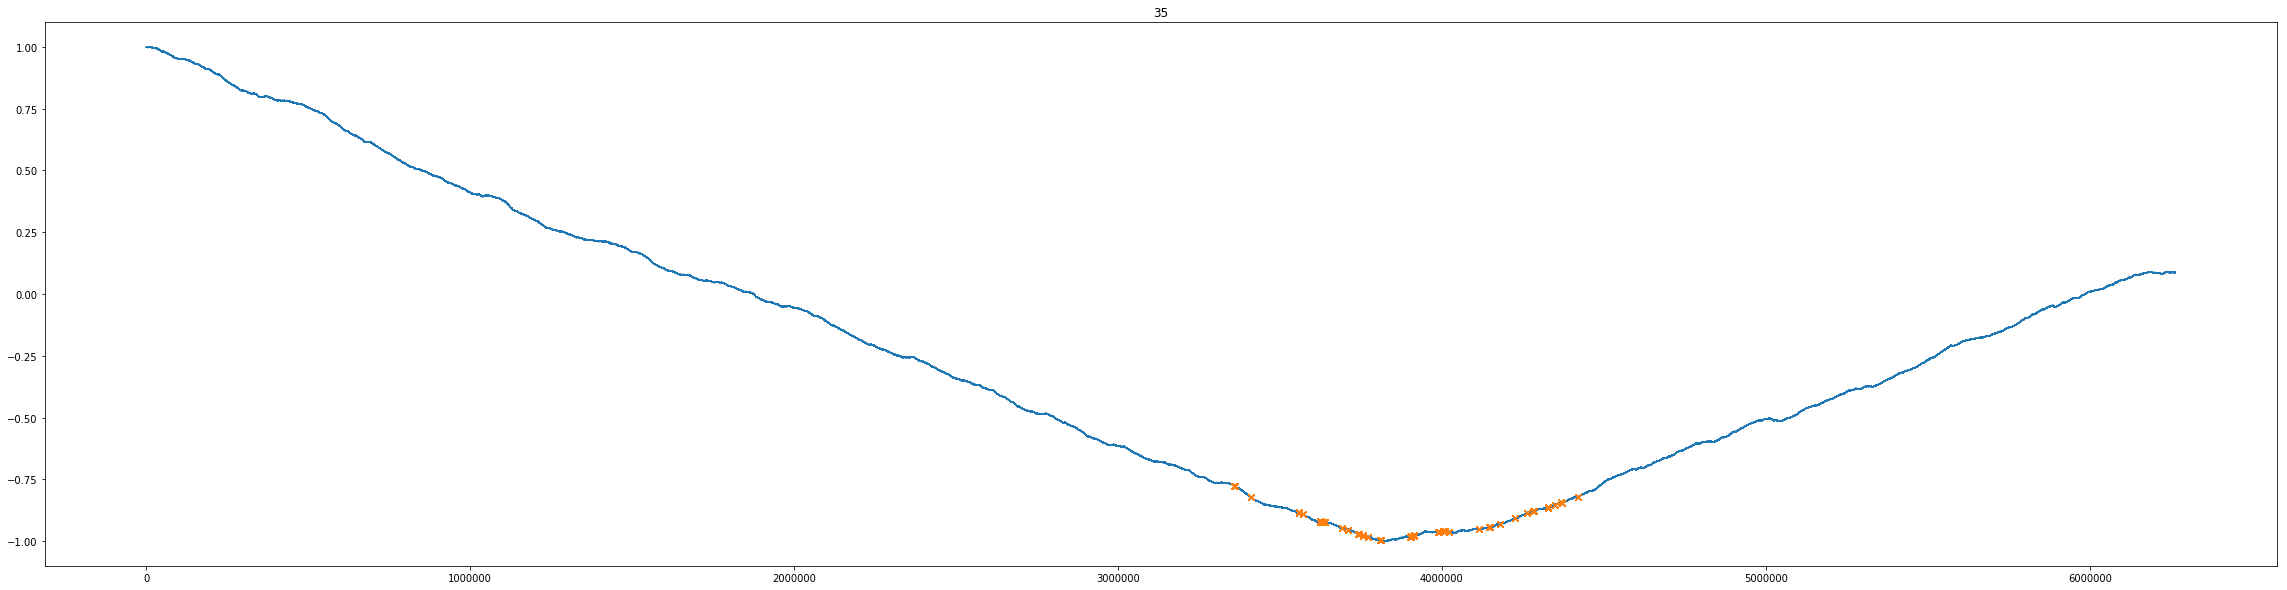

In [40]:
x = prcoess_and_filter_all_nc_regions_list(all_nc_regions, [6,7,8,9], occurance_threshold=4)

orite.plot_region_list(curve=score_curve, region_list=x, rotated=True)

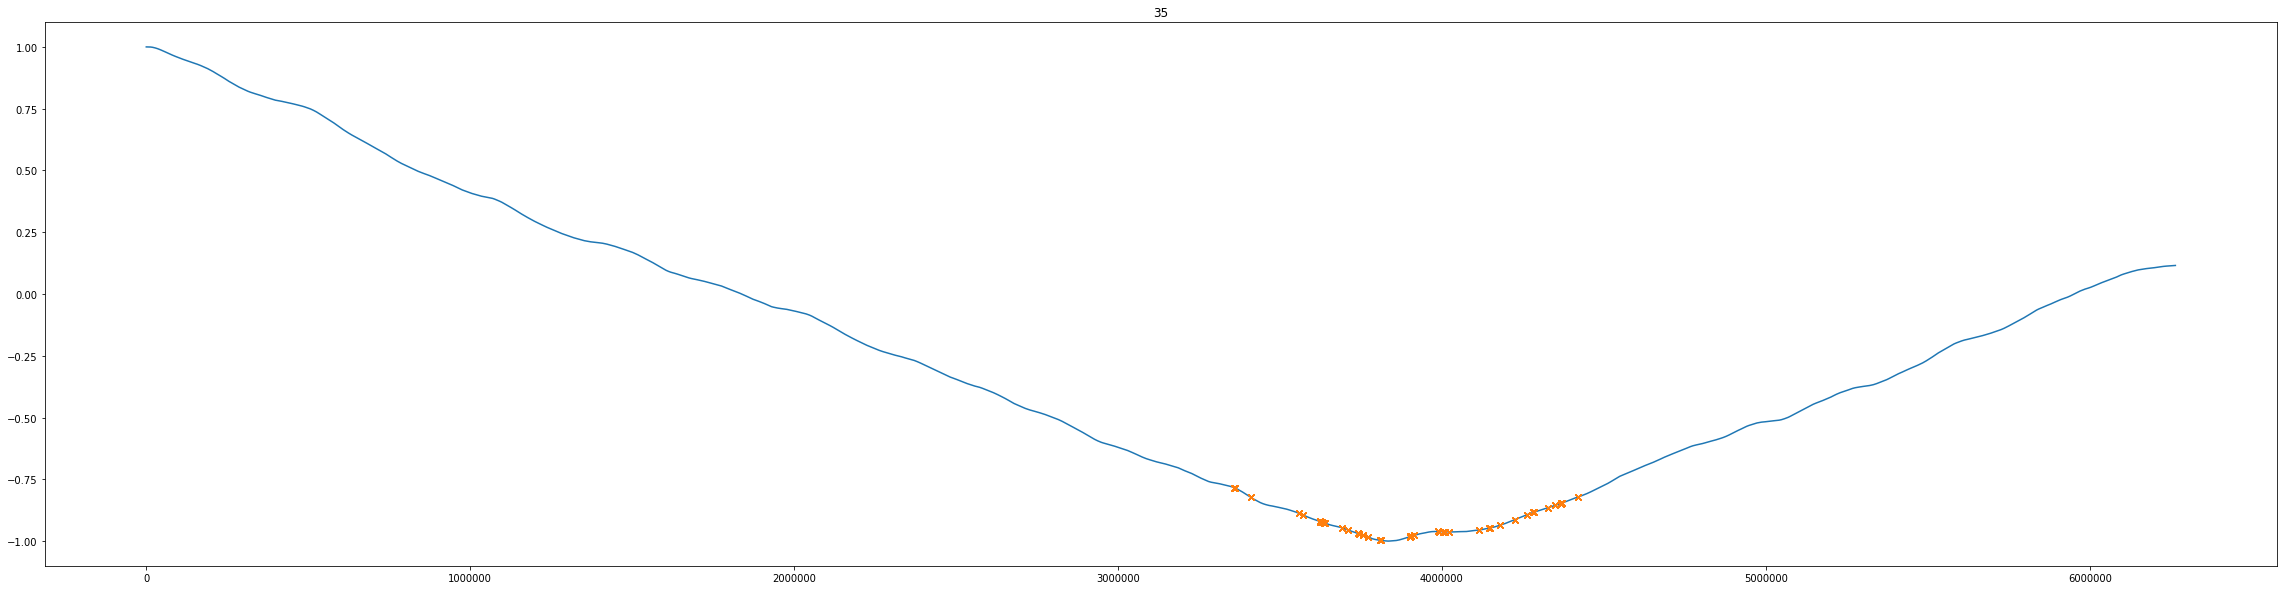

In [41]:


orite.plot_region_list(curve=cgc_scaled, region_list=x, rotated=True)





In [42]:
orite.print_region_list_kmer_info(x)

region: 0 ---  score:  0.9949340589273166 ---- pos:  6224482 ---- max_relative_start_pos 3808786
	k= 6
	 CGGCGG  -  [4, 166, 200, 245, 295]  -  density: 0.031007751937984496
	 GGCGCG  -  [4, 83, 154, 263, 382]  -  density: 0.013377926421404682
	-------
region: 1 ---  score:  0.9946284204082576 ---- pos:  6225926 ---- max_relative_start_pos 3810230
	k= 6
	 CGGCAG  -  [5, 429, 477, 522, 531, 633]  -  density: 0.024509803921568627
	 CGCGCA  -  [6, 247, 368, 377, 485, 503, 538]  -  density: 0.020618556701030927
	 CCGGCA  -  [4, 428, 463, 530, 632]  -  density: 0.0196078431372549
	 CAGCGC  -  [7, 514, 553, 612, 654, 735, 900, 949]  -  density: 0.016091954022988506
	 CCAGCA  -  [4, 668, 896, 938, 974]  -  density: 0.013071895424836602
	 CGGCGC  -  [4, 217, 334, 374, 548]  -  density: 0.012084592145015106
	 ACGGCG  -  [4, 216, 333, 373, 547]  -  density: 0.012084592145015106
	 CAGCAG  -  [4, 588, 841, 897, 975]  -  density: 0.0103359173126615
	k= 7
	 ACGGCGC  -  [4, 216, 333, 373, 547]  -  de

	 TACGCGAT  -  [5, 17, 120, 221, 322, 423]  -  density: 0.012315270935960592
	 CTACGCGA  -  [5, 16, 119, 220, 321, 422]  -  density: 0.012315270935960592
	 CCTACGCG  -  [5, 15, 118, 219, 320, 421]  -  density: 0.012315270935960592
	k= 9
	 GCGGATAAC  -  [5, 45, 92, 193, 294, 395]  -  density: 0.014285714285714285
	 GGCGGATAA  -  [5, 44, 91, 192, 293, 394]  -  density: 0.014285714285714285
	 AGCGGTTAT  -  [4, 105, 206, 307, 408]  -  density: 0.013201320132013201
	 GATAACCGC  -  [4, 95, 196, 297, 398]  -  density: 0.013201320132013201
	 GGATAACCG  -  [4, 94, 195, 296, 397]  -  density: 0.013201320132013201
	 CGGATAACC  -  [4, 93, 194, 295, 396]  -  density: 0.013201320132013201
	 CGGCGGATA  -  [4, 90, 191, 292, 393]  -  density: 0.013201320132013201
	 CGAAGCCCG  -  [4, 80, 181, 282, 383]  -  density: 0.013201320132013201
	 CCGAAGCCC  -  [4, 79, 180, 281, 382]  -  density: 0.013201320132013201
	 ACCGAAGCC  -  [4, 78, 179, 280, 381]  -  density: 0.013201320132013201
	 CACCGAAGC  -  [4, 77, 

In [43]:
test_region  = x[0]

In [44]:
density_data = []

for region in x:
    
    kdic = region.kmer_info
    
    for k, val in kdic.items():
        
        for kmer_row in val:
            density_data.append(kmer_row[2])

In [45]:
len(density_data)

261

(array([  8., 187.,  19.,   5.,  10.,   7.,   3.,   3.,   7.,   3.,   1.,
          3.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.01017812, 0.01202584, 0.01387356, 0.01572128, 0.017569  ,
        0.01941672, 0.02126444, 0.02311216, 0.02495987, 0.02680759,
        0.02865531, 0.03050303, 0.03235075, 0.03419847, 0.03604619,
        0.03789391, 0.03974163, 0.04158935, 0.04343707, 0.04528479,
        0.04713251, 0.04898023, 0.05082795, 0.05267567, 0.05452339,
        0.05637111, 0.05821883, 0.06006655, 0.06191427, 0.06376199,
        0.06560971, 0.06745743, 0.06930515, 0.07115287, 0.07300059,
        0.07484831, 0.07669603, 0.07854375, 0.08039147, 0.08223919,
        0.08408691, 0.08593463, 0.08778234, 0.08963006, 0.09147778,
        0.0933255 , 0.09517322, 0.09702094, 0.

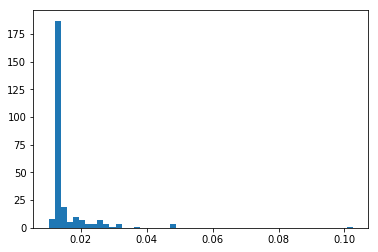

In [46]:
a, b = np.histogram(density_data, bins=50)
plt.hist(density_data, b)